# Forecasting antidiabetic drug prescriptions in Australia

The scope of this project is to forecast the number of antidiabetic drug prescriptions from 1991 to 2008 in Australia. The data used here come from the *Australian Health Insurance Commission*.

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from itertools import product
from typing import Union

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

Here the objective is to forecast 12 months of antidiabetic drug prescriptions using a Time Series forecasting model.

We start by visualizing the data:

In [2]:
# import data

data = pd.read_csv('AusAntidiabeticDrug.csv')
print(f'Shape of the data: {data.shape}')

Shape of the data: (204, 2)


In [3]:
data.head(10)

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
5,1991-12-01,4.306371
6,1992-01-01,5.088335
7,1992-02-01,2.814520
8,1992-03-01,2.985811
9,1992-04-01,3.204780


In [4]:
data.tail(10)

,ds,y
194,2007-09-01,22.930357
195,2007-10-01,23.263340
196,2007-11-01,25.250030
197,2007-12-01,25.806090
198,2008-01-01,29.665356
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


Note that we have a measure for each month, starting in July 1991 and ending in June 2008.

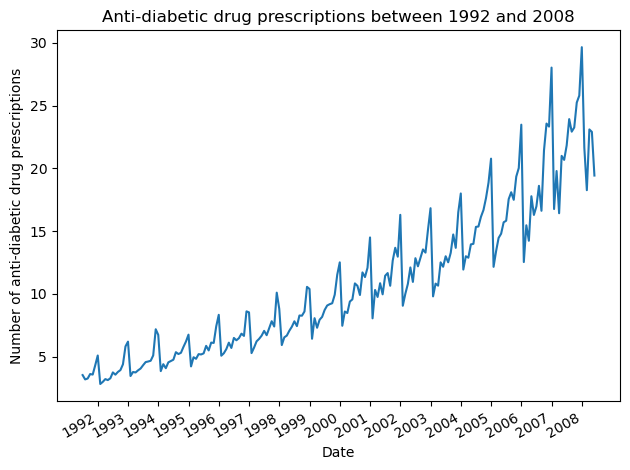

In [5]:
# plot data

fig, ax = plt.subplots()

ax.plot(data['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009))
plt.title('Anti-diabetic drug prescriptions between 1992 and 2008')

fig.autofmt_xdate()
plt.tight_layout()


We see from the graph that there is a trend on the data, together with a seasonality. Let's check that:

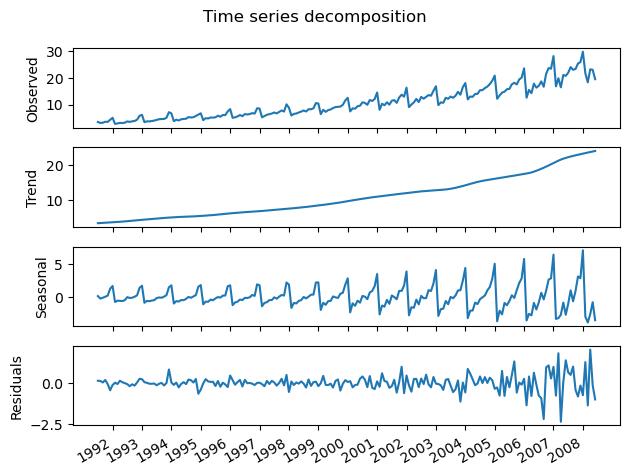

In [6]:
# decompose by seasonality (12 months in a year)
data_decomposition = STL(data['y'], period=12).fit()

# plot time series components

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(data_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(data_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(data_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(data_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009))
fig.suptitle('Time series decomposition')

fig.autofmt_xdate()
plt.tight_layout()

It seems that the best model for forecasting is *SARIMA*, since there is a clear seasonality. We can avoid using *SARIMAX* since there are no exogenous variables.

### SARIMA modeling

The aim of this section is to find a good $\text{SARIMA}(p,d,q)(P,D,Q)_m$ model by finding the parameters.

We start by looking at the stationarity of the series by means of the augmented *Dickey-Fuller test* (ADF):

In [7]:
# ADF test

adf = adfuller(data['y'])

print(f'ADF statistics: {adf[0]}')
print(f'ADF p-value: {adf[1]}')

ADF statistics: 3.1451856893067394
ADF p-value: 1.0


A $p$-value of 1 means that we cannot reject the null hypothesis, and so the series is not stationary. Thus, we must apply a first-order differencing:

In [8]:
# first order differencing and new ADF test

data_diff = np.diff(data['y'], n=1)

adf = adfuller(data_diff)

print(f'ADF statistics: {adf[0]}')
print(f'ADF p-value: {adf[1]}')

ADF statistics: -2.4951721474496837
ADF p-value: 0.11665341686470149


The $p$-value is still above 0.05, so we have to differenccing again. Since seasonality is present, we can apply a seasonal difference, using $m=12$:

In [9]:
# seasonal differencing and new ADF test

data_seasonal_diff = np.diff(data['y'], n=12)

adf = adfuller(data_seasonal_diff)

print(f'ADF statistics: {adf[0]}')
print(f'ADF p-value: {adf[1]}')

ADF statistics: -18.779669953887357
ADF p-value: 2.0243648095239745e-30


With a $p$-value of $2 \cdot 10^{-30}$, we can safely reject the null hypothesis, and so the transformed time series is stationary.

Since it takes only one seasonal difference, we have found the values for some parameters:
+ $d=1$
+ $D=1$
+ $m=12$

Next step is to find optimal values for $p,q,P,Q$. We will do that using the *Akaike information criterion* (AIC).

We split the data into train and test sets, the latter consisting of the last 36 months of data:

In [10]:
# train-test split

train = data.y[:168]
test = data.y[168:]

print(f'Length of test set: {len(test)}')

Length of test set: 36


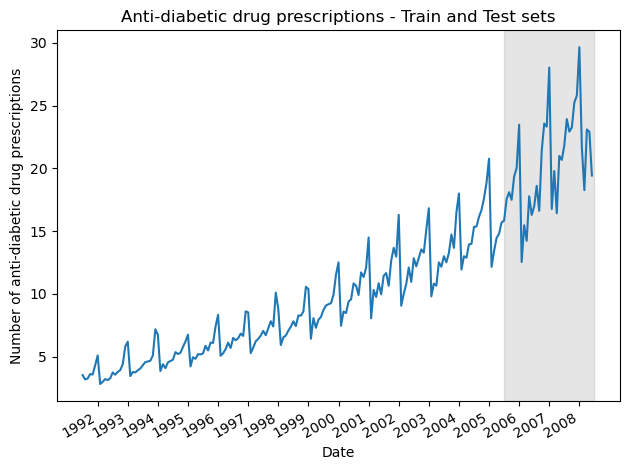

In [11]:
fig, ax = plt.subplots()

ax.plot(data['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009))
plt.title('Anti-diabetic drug prescriptions - Train and Test sets')

fig.autofmt_xdate()
plt.tight_layout()

Then we write a function that find which values of the parameters minimize the AIC:

In [12]:
# optimization function

def opt_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, m: int) -> pd.DataFrame:
    
    results = []
    
    for order in order_list:
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], m),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df
            

Now we can decide which values of the parameters $p,q,P,Q$ to try:

In [15]:
# param values range

ps = range(0,5)
qs = range(0,5)
Ps = range(0,5)
Qs = range(0,5)

order_list = list(product(ps, qs, Ps, Qs))

# initialize known params

d = 1
D = 1
m = 12

We thus run our function and look for the minimum AIC (it can take some time):

In [16]:
# run opt_SARIMA

params_result = opt_SARIMA(train, order_list, d, D, m)
params_result

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.214449
2,"(3, 3, 1, 3)",271.384165
3,"(4, 1, 1, 3)",272.145292
4,"(0, 4, 1, 3)",272.152380
...,...,...
620,"(0, 0, 0, 4)",351.680917
621,"(0, 0, 2, 4)",353.221910
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


From the table we see that the minimum AIC is achieved with
+ $p=3$
+ $q=1$
+ $P=1$
+ $Q=3$

Thus the optimal model (among the tested ones) is a $\text{SARIMA}(3,1,1)(1,1,3)_{12}$.

### Model fitting and and residuals analysis

At this point, we can initialize and fit our model:

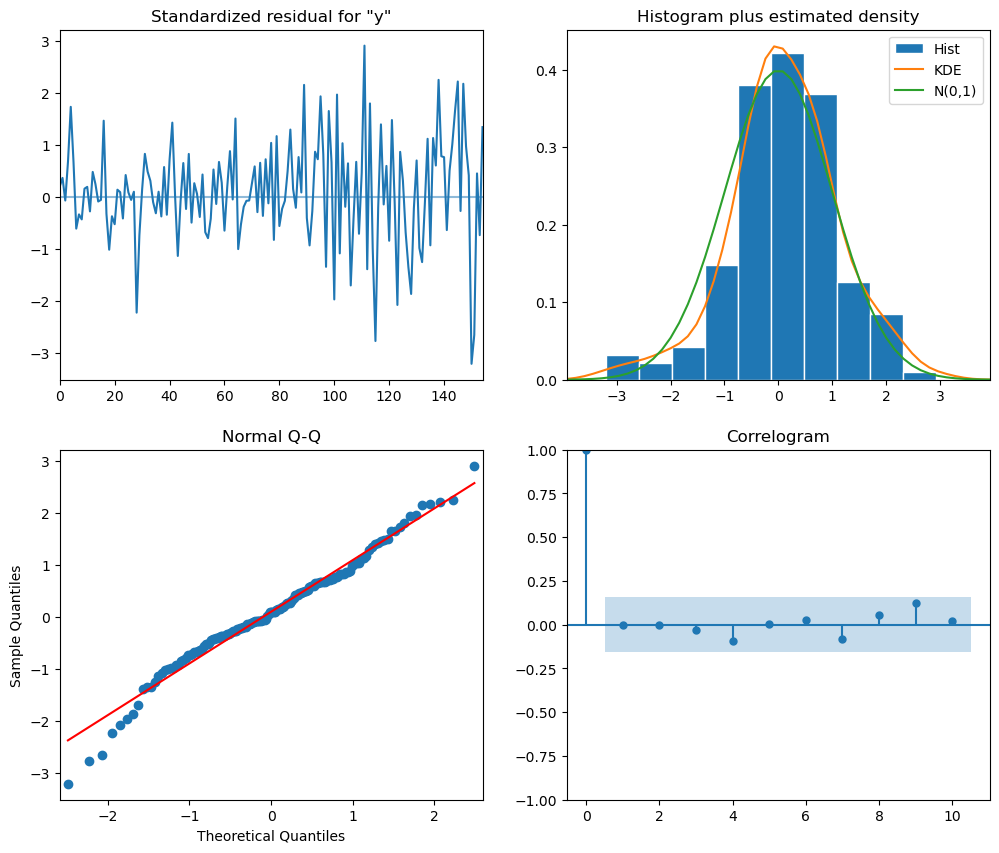

In [17]:
# model fitting and diagnostics

model = SARIMAX(
    train,
    order=(3,1,1),
    seasonal_order=(1,1,3,12),
    simple_differencing=False)

model_fit = model.fit(disp=False)

model_fit.plot_diagnostics(figsize=(12,10));

From this qualitative analysis, we can conclude that the residuals are comparable to white noise. To check the uncorrelation and independence of residuals, we perform the *Ljung-Box* test. This test's null hypothesis staets that the residuals are uncorrelated, so we hope the test will return high $p$-values (above 0.05). In that case, we can say that the residuals actually behave like white noise.

In [18]:
# ljung-box test

residuals = model_fit.resid

lb_test = acorr_ljungbox(residuals, np.arange(1,11))
lb_test

,lb_stat,lb_pvalue
1,0.436625,0.508756
2,0.627091,0.730851
3,0.645642,0.885909
4,2.257627,0.688494
5,2.949519,0.707768
6,3.388368,0.758758
7,9.980970,0.189654
8,10.590818,0.225979
9,11.852408,0.221758
10,11.983795,0.286143


All $p$-values are above 0.05, and therefore we can conclude that the residuals are independent and uncorrelated. 

### Predictions and performance evaluation

Finally, we have selected a (hopefully good) model. Now we can forecast the last 36 months. We first define a function that generates the predictions:

In [25]:
# forecasting function

def forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'SARIMA':
        
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(
                df['y'][:i],
                order=(3,1,1),
                seasonal_order=(1,1,3,12),
                simple_differencing=False)
            res = model.fit(disp=False)
            pred = res.get_prediction(0, i + window -1)
            oos_pred = pred.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA
    
    elif method == 'season':

        pred_season = []

        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_season.extend(last_season)

        return pred_season

To make things easier, we create a dataframe to hold both predictions and true values:

In [22]:
# copy test dataframe

predictions_df = data[168:]

Then we use the forecasting funciton to make predictions, and to do that we need to initialize the parameters needed:

In [23]:
# parameters

TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

In order to have a baseline, we make a naive seasonal forecast:

In [26]:
# baseline predictions

predictions_df['last_season'] = forecast(data, TRAIN_LEN, HORIZON, WINDOW, 'season')

Next we make predictions using our SARIMA model:

In [27]:
# SARIMA predictions

predictions_df['SARIMA'] = forecast(data, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

In [28]:
# predictions dataframe

predictions_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.746016
169,2005-08-01,17.554701,15.370764,16.619454
170,2005-09-01,18.100864,16.142005,17.255372
171,2005-10-01,17.496668,16.685754,18.107641
172,2005-11-01,19.347265,17.636728,18.722412
173,2005-12-01,20.031291,18.869325,19.885738
174,2006-01-01,23.486694,20.778723,22.216711
175,2006-02-01,12.536987,12.154552,13.544394
176,2006-03-01,15.467018,13.402392,14.972350
177,2006-04-01,14.233539,14.459239,15.593444


Since it is difficult to appreciate the data in the table, we plot them:

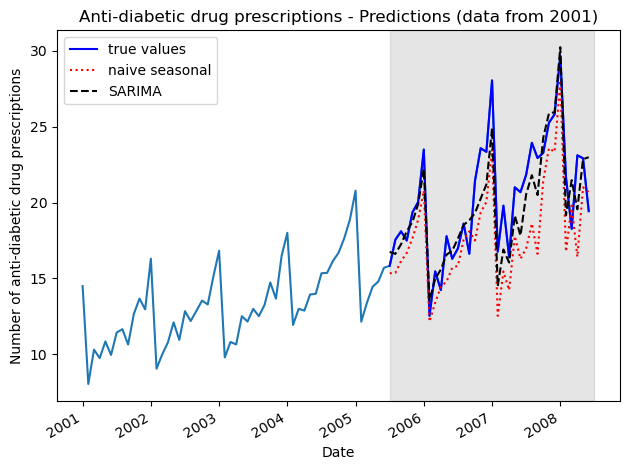

In [34]:
fig, ax = plt.subplots()

ax.plot(data['y'][114:]) # for a more clear graph, we start from 2001
ax.plot(predictions_df['y'], 'b-', label='true values')
ax.plot(predictions_df['last_season'], 'r:', label='naive seasonal')
ax.plot(predictions_df['SARIMA'], 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(114, 203, 12), np.arange(2001, 2009))
plt.title('Anti-diabetic drug prescriptions - Predictions (data from 2001)')

fig.autofmt_xdate()
plt.tight_layout()

We clearly see that SARIMA is much more accurate than naive seasonal method. Let's evaluate the performance quantitatively by using the *mean absolute percentage error* (MAPE):

In [35]:
# mape function

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
# evaluate models

mape_naive_seasonal = mape(predictions_df['y'], predictions_df['last_season'])
mape_SARIMA = mape(predictions_df['y'], predictions_df['SARIMA'])

print(f'The MAPE for naive seasonal method is: {round(mape_naive_seasonal, 2)}%.')
print(f'The MAPE for SARIMA method is: {round(mape_SARIMA,2)}%.')

The MAPE for naive seasonal method is: 12.69%.
The MAPE for SARIMA method is: 7.56%.


Thus the SARIMA model is more accurate (error 7.56%) than the baseline one (error 12.69%).